In [119]:
%cd ~/fur/
import math
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
shift_03_10_2020 = path_assistant.PathAssistant('shift_03_10_2020',      
    ignore_files=["RefCurve_2020-03-10_0_111937_test.Wfm.bin"])
#shift_03_10_2020.show_waveform_file_names()
waveforms_dir = shift_03_10_2020.get_waveforms_dir()


/home/ilobach/fur


In [120]:
test_file = shift_03_10_2020.get_waveform_path('RefCurve_2020-03-10_1_113153.Wfm.bin')
ch1, ch2 = read_waveform(test_file)
new_len = int(1.0*len(ch1))
ch1,ch2 = ch1[:new_len],ch2[:new_len]
data_len = len(ch1)

In [121]:
dt0 = 0.04 # ns

In [122]:
period = get_period(ch2)
period

3332.448088326239

In [123]:
times_within_period = np.arange(data_len) % period

In [124]:
n_bins = 1000
bin_size = period/n_bins
bins = np.linspace(0, period, n_bins+1)
bin_centers = (bins[:-1]+bins[1:])/2
bin_ranges = np.vstack((bins[:-1],bins[1:])).T


In [125]:
df = pd.DataFrame({"time":times_within_period, "ch1":ch1, "ch2": ch2})

In [126]:
df0 = df.groupby(df["time"]//bin_size)

In [127]:
df1 = df0['ch1'].apply(np.asarray)

In [128]:
var_ch1 = [np.var(arr) for arr in df1]

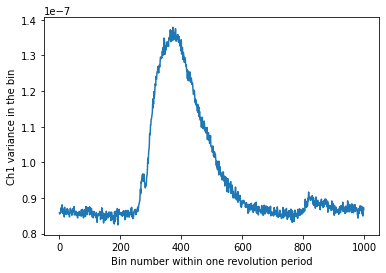

In [129]:
plt.plot(var_ch1)
plt.xlabel("Bin number within one revolution period")
plt.ylabel("Ch1 variance in the bin")
plt.show()

In [134]:
ch1_mean = df0["ch2"].apply(np.mean)
ch1_mean = ch1_mean-min(ch1_mean)
ch1_mean_squared = ch1_mean.values**2

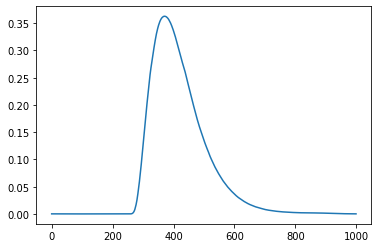

In [135]:
plt.plot(ch1_mean_squared)

In [136]:
noise_var_0 = min(var_ch1)
fluct_V_0 = (max(var_ch1)-min(var_ch1))
max_ch1_mean_squared = max(ch1_mean_squared)
normalized_ch1_mean_squared = ch1_mean_squared/max_ch1_mean_squared

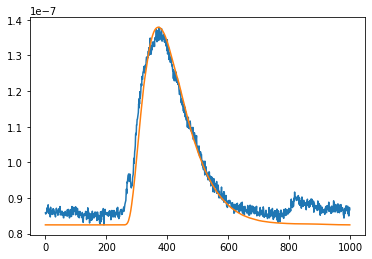

In [137]:
plt.plot(var_ch1)
plt.plot(noise_var_0+fluct_V_0*normalized_ch1_mean_squared)

In [138]:
reg = linear_model.LinearRegression()
x = normalized_ch1_mean_squared
y = var_ch1
reg.fit(x.reshape((len(x), 1)), y)
fluct_V_f = reg.coef_[0]
noise_var_f = reg.intercept_

In [106]:
def f(p):
    fluct_V, noise_var = p
    return np.sum((var_ch1-(noise_var+fluct_V*normalized_ch1_mean_squared))**2)

In [109]:
p0 = [fluct_V_0, noise_var_0]
res = minimize(f,p0)
print(res)
fluct_V_f, noise_var_f = res.x

fun: 1.2112838820563532e-14
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([2.13857796e-06, 1.07259315e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 408
      nit: 0
     njev: 99
   status: 2
  success: False
        x: array([5.543516e-08, 8.245133e-08], dtype=float32)


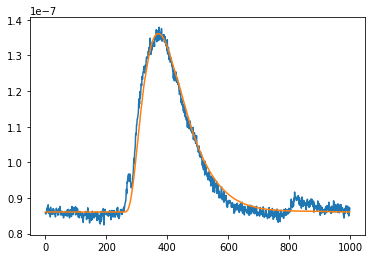

In [139]:
plt.plot(var_ch1)
plt.plot(noise_var_f+fluct_V_f*normalized_ch1_mean_squared)

In [195]:
def CalcAmpFluct(file_name):
    ch2, ch1 = read_waveform(file_name)

    n0=2640
    cut = 200
    ch1 = ch1[cut*n0:-cut*n0]
    ch2 = ch2[cut*n0:-cut*n0]

    ch1Min = min(ch1)
    ch1 = [c1-ch1Min for c1 in ch1]

    n0=2640

    amplitude = max(ch1)-min(ch1)
    tl = amplitude/2+min(ch1)
    trig_times = []
    n_tc = 30
    y0=0
    for x in range(n_tc,len(ch1)):
        y=ch1[x]
        if y0<tl and y>tl and ch1[x-n_tc]<tl and ch1[x+n_tc]>tl:
            X = [i-x for i in range(x-n_tc,x+n_tc)]
            Y = [j-tl for j in ch1[x-n_tc:x+n_tc]]
            XY = [i*j for i,j in zip(X,Y)]
            X2 = [i**2 for i in X]
            m = (np.mean(XY)-np.mean(X)*np.mean(Y))/(np.mean(X2)-np.mean(X)**2)
            b = np.mean(Y)-m*np.mean(X)
            trig_times.append(x-b/m)
        y0=y
        x+=1000

    periods = [0]*(len(trig_times)-1)
    for i in range(len(periods)):
        periods[i]=trig_times[i+1]-trig_times[i]
    periods = [p for p in periods if p>0.9*n0]

    mean_period = np.mean(periods)
    print("mean_period =",mean_period)
    T=mean_period
    periods_std = np.std(periods)
    print("periods_std =",periods_std)
    period_error = periods_std/math.sqrt(len(periods))
    print("period_error =",period_error)
    
    del periods

    time_shift = -trig_times[1]+200
    ts = [(t+time_shift)%T for t in range(len(ch1))]

    T_int = math.ceil(T)
    T_int

    p = 1*T_int
    tt = ts[0:p]
    cc = ch1[0:p]

    int_xs = range(T_int)
    itp = interp1d(tt,cc)
    cc_savgol = list(scipy.signal.savgol_filter(itp(int_xs[1:-1]),51,3))
    cc_savgol = [cc_savgol[0]]+cc_savgol+[cc_savgol[-1]]

    del ch1

    n_bins =  T_int
    binned_ch2 = [[] for i in range(n_bins)]
    for i in range(len(ts)):
        t = ts[i]
        j = math.floor(n_bins*t/T)
        binned_ch2[j].append(ch2[i])

    var_ch2 = [np.var(correct_his(i)) for i in binned_ch2]
    
    del binned_ch2

    # plt.plot(var_ch2)
    # plt.show()

    def finite_diff(ch1t,diff_n):
        ch1_diff = [0]*len(ch1t)
        for i in range(diff_n+1,len(ch1_diff)-diff_n-1):
            ch1_diff[i]=least_squares_0(range(-diff_n,diff_n+1),ch1t[i-diff_n:i+diff_n+1])
        return ch1_diff

    int_xs = range(T_int)
    int_ch1 = cc_savgol# [f1(i) for i in int_xs]

    int_ch1_c = int_ch1
    var_ch2_c = var_ch2_c = list(scipy.signal.savgol_filter(var_ch2,101,3))
    plt.plot(var_ch2_c,"x")

    index,value = max(enumerate(int_ch1_c),key=operator.itemgetter(1))
    delta = 30
    plt.axvline(index-delta,color='r')
    plt.axvline(index+delta,color='r')
    h2 = np.mean(var_ch2_c[index-delta:index+delta])

    m1,m2,m3,m4=0,60,1400,1900
   
    plt.axvline(m3,color='g')
    plt.axvline(m4,color='g')

    h1 = np.mean(var_ch2_c[m3:m4])

    plt.axhline(h1,color='b')
    plt.axhline(h2,color='b')

    min_int_ch1_c=min(int_ch1_c)
    s_amp = (value-min(int_ch1_c))/2
    a0 = s_amp*2/0.7
    fluct = (h2-h1)/2/s_amp**2
    fluct_V = a0**2*fluct
    ch1_rescaled = [h1+(h2-h1)/(value-min_int_ch1_c)**2*(i-min_int_ch1_c)**2 for i in int_ch1_c]
    plt.plot(ch1_rescaled,color='yellow')


    plt.show()



    print("fluct_V =",fluct_V,"V^2")
    print("a0 =",a0,"V")
    print("fluct = ",fluct)

    with open(path.join(directory,"new_data_analyzer_3_31_6_better_signal_averaging_new.txt"), 'a') as the_file:
                    the_file.write(file+";"+str(a0)+";"+str(fluct_V)+";"+str(fluct)+"\n")
    print("Done with "+file)
    print("----------------------------------------------------------------------------------------------------------")

    return [file_name,a0,fluct_V,fluct]

In [196]:
CalcAmpFluct(test_file)

mean_period = 3332.431636818763
periods_std = 0.4773606065439201


NameError: name 'math' is not defined